In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [3]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Flavors.xlsx", encoding = 'unicode_escape')

In [4]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l1,label_l2,label_l3,label_l4,label_l5
0,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Brandy,Not assigned,R71,Flavors,40614069,Flavor Cherry Brandy Bottle 5kg,...,N001/Not assigned,0010/#,0010/Not assigned,447.85,447.85,Flavors,Fla/ Sweet,NaN,NaN,NaN
1,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,ZZ Fla/Swe/A&W/ Other,Not assigned,R71,Flavors,43692564,Flavor Pinacolada 55577-DO Givaudan BDZ,...,N001/Not assigned,0047/#,0047/Not assigned,52680.73,7701.62,Flavors,Fla/ Sweet,NaN,NaN,NaN
2,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43770855,FlavorWhiskeyBourbonGIV AY8652126KshrNGM,...,N001/Not assigned,0042/#,0042/Not assigned,43650.60,43355.09,Flavors,Fla/ Sweet,NaN,NaN,NaN
3,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43842799,Flavor Wine Powder GIV TL-937-491-1,...,N001/Not assigned,0042/#,0042/Not assigned,121079.53,119888.26,Flavors,Fla/ Sweet,NaN,NaN,NaN
4,Raw,Flavors,Fla/ Sweet,ZZ Fla/Swe/ Alcohol,Not assigned,Not assigned,R71,Flavors,43885774,Flavor Hazelnut Liquid IFF SN378872,...,N001/Not assigned,0051/#,0051/Not assigned,125580.00,17856.29,Flavors,Fla/ Sweet,NaN,NaN,NaN


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])

df["CONCATED_COLUMN"] = df["material_descr_from_po"]+" "+df["vendor_desc"]+" "+df["account_number_desc"]+" "+df["cost_center_desc"]

# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [6]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc","CONCATED_COLUMN"]
y_column = ["label_l2_enc"]
seed = 10

In [7]:
df.label_l2.value_counts()

Fla/ Sweet     4470
Fla/ Savory    2845
Name: label_l2, dtype: int64

In [8]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [9]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [11]:
print("Train sample : %.0f "% (X_train.shape[0]))
print("Valid sample : %.0f "% (X_valid.shape[0]))
print("Test sample : %.0f "% (X_test.shape[0]))

Train sample : 4681 
Valid sample : 1171 
Test sample : 1463 


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

selected_col = "CONCATED_COLUMN"

sentences_train = X_train[selected_col].values
sentences_valid = X_valid[selected_col].values
sentences_test = X_test[selected_col].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)


maxlen = 26


X_train = X_train.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_train), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_test = X_test.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_test), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
X_valid = X_valid.merge(pd.DataFrame(pad_sequences(tokenizer.texts_to_sequences(sentences_valid), padding='post', maxlen=maxlen)),left_index=True, right_index = True)
# X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# print(sentences_train[2])
# print(X_train[2])

In [13]:
# from sklearn.feature_extraction.text import CountVectorizer

# for selected_col in x_column:
#     sentences_train = X_train[selected_col].values
#     sentences_valid = X_valid[selected_col].values
#     sentences_test = X_test[selected_col].values

#     vectorizer = CountVectorizer()
#     vectorizer.fit(sentences_train)

#     X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
#     X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
#     X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [14]:
all_col = list(X_train.columns)

In [15]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')
all_col.remove('CONCATED_COLUMN')

In [16]:
from keras.utils import to_categorical

# NN Model 

In [19]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 20)            137600    
_________________________________________________________________
flatten_2 (Flatten)          (None, 520)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5210      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 142,832
Trainable params: 142,832
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [21]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9974
Valid Accuracy:  0.8898
Testing Accuracy:  0.8934


In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

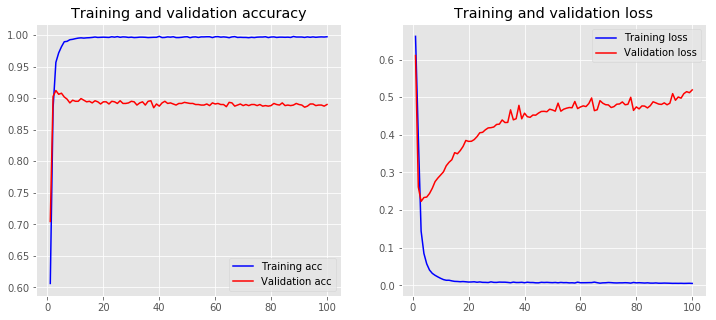

In [23]:
plot_history(history)

# Hyperparameter Tuning

In [24]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [30]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_dense=10):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense, activation=activation))
    model.add(layers.Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [31]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001],
          'embedding_dim' : [10,15,20,25,30],
          'n_dense' : [5,10,15,20]
         }

In [32]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [33]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [34]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
3120/3120 [==============================] - 1s 193us/step - loss: 0.6372 - accuracy: 0.6218
Epoch 2/10
3120/3120 [==============================] - 0s 100us/step - loss: 0.3556 - accuracy: 0.9032
Epoch 3/10
3120/3120 [==============================] - 0s 97us/step - loss: 0.1715 - accuracy: 0.9497
Epoch 4/10
3120/3120 [==============================] - 0s 117us/step - loss: 0.1056 - accuracy: 0.9686
Epoch 5/10
3120/3120 [==============================] - 0s 117us/step - loss: 0.0727 - accuracy: 0.9798
Epoch 6/10
3120/3120 [==============================] - 0s 88us/step - loss: 0.0540 - accuracy: 0.9856
Epoch 7/10
3120/3120 [==============================] - 0s 92us/step - loss: 0.0433 - accuracy: 0.9878
Epoch 8/10
3120/3120 [==============================] - 0s 95us/step - loss: 0.0353 - accuracy: 0.9888
Epoch 9/10
3120/3120 [==============================] - 0s 93us/step - loss: 0.0299 - accuracy: 0.9920
Epoch 10/10
3120/3120 [==========================

3121/3121 [==============================] - 1s 267us/step - loss: 0.0118 - accuracy: 0.9962
Epoch 15/30
3121/3121 [==============================] - 1s 245us/step - loss: 0.0149 - accuracy: 0.9952
Epoch 16/30
3121/3121 [==============================] - 1s 281us/step - loss: 0.0121 - accuracy: 0.9952
Epoch 17/30
3121/3121 [==============================] - 1s 347us/step - loss: 0.0098 - accuracy: 0.9962
Epoch 18/30
3121/3121 [==============================] - 1s 245us/step - loss: 0.0092 - accuracy: 0.9965
Epoch 19/30
3121/3121 [==============================] - 1s 243us/step - loss: 0.0085 - accuracy: 0.9958
Epoch 20/30
3121/3121 [==============================] - 1s 241us/step - loss: 0.0075 - accuracy: 0.9962
Epoch 21/30
3121/3121 [==============================] - 1s 244us/step - loss: 0.0074 - accuracy: 0.9971
Epoch 22/30
3121/3121 [==============================] - 1s 245us/step - loss: 0.0068 - accuracy: 0.9955
Epoch 23/30
3121/3121 [==============================] - 1s 249us/s

3121/3121 [==============================] - 2s 602us/step - loss: 0.0064 - accuracy: 0.9990
Epoch 8/10
3121/3121 [==============================] - 2s 556us/step - loss: 0.0045 - accuracy: 0.9994
Epoch 9/10
3121/3121 [==============================] - 2s 592us/step - loss: 0.0028 - accuracy: 0.9997
Epoch 10/10
3121/3121 [==============================] - 1s 244us/step
Epoch 1/30
3120/3120 [==============================] - 1s 455us/step - loss: 0.6659 - accuracy: 0.5910
Epoch 2/30
3120/3120 [==============================] - 1s 161us/step - loss: 0.4971 - accuracy: 0.7917
Epoch 3/30
3120/3120 [==============================] - 1s 274us/step - loss: 0.1966 - accuracy: 0.9410
Epoch 4/30
3120/3120 [==============================] - 1s 188us/step - loss: 0.1022 - accuracy: 0.9667
Epoch 5/30
3120/3120 [==============================] - 1s 202us/step - loss: 0.0707 - accuracy: 0.9756
Epoch 6/30
3120/3120 [==============================] - 0s 158us/step - loss: 0.0501 - accuracy: 0.9837
Epoc

3121/3121 [==============================] - 0s 77us/step - loss: 0.0040 - accuracy: 0.9997
Epoch 13/30
3121/3121 [==============================] - 0s 69us/step - loss: 0.0036 - accuracy: 0.9997
Epoch 14/30
3121/3121 [==============================] - 0s 70us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 15/30
3121/3121 [==============================] - 0s 70us/step - loss: 0.0027 - accuracy: 0.9997
Epoch 16/30
3121/3121 [==============================] - 0s 70us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 17/30
3121/3121 [==============================] - 0s 72us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 18/30
3121/3121 [==============================] - 0s 68us/step - loss: 0.0021 - accuracy: 0.9997
Epoch 19/30
3121/3121 [==============================] - 0s 69us/step - loss: 0.0019 - accuracy: 0.9997
Epoch 20/30
3121/3121 [==============================] - 0s 69us/step - loss: 0.0017 - accuracy: 0.9997
Epoch 21/30
3121/3121 [==============================] - 0s 73us/step - loss

3121/3121 [==============================] - 0s 95us/step - loss: 0.0027 - accuracy: 0.9994
Epoch 18/20
3121/3121 [==============================] - 0s 69us/step - loss: 0.0022 - accuracy: 0.9997
Epoch 19/20
3121/3121 [==============================] - 0s 67us/step - loss: 0.0020 - accuracy: 0.9994
Epoch 20/20
3121/3121 [==============================] - 0s 18us/step
Epoch 1/20
3120/3120 [==============================] - 1s 284us/step - loss: 0.6118 - accuracy: 0.6766
Epoch 2/20
3120/3120 [==============================] - 1s 180us/step - loss: 0.2969 - accuracy: 0.9202
Epoch 3/20
3120/3120 [==============================] - 1s 176us/step - loss: 0.1478 - accuracy: 0.9587
Epoch 4/20
3120/3120 [==============================] - 1s 176us/step - loss: 0.0922 - accuracy: 0.9756
Epoch 5/20
3120/3120 [==============================] - 1s 180us/step - loss: 0.0640 - accuracy: 0.9830
Epoch 6/20
3120/3120 [==============================] - 1s 178us/step - loss: 0.0491 - accuracy: 0.9865
Epoch 

3120/3120 [==============================] - 0s 65us/step
Epoch 1/10
3121/3121 [==============================] - 1s 305us/step - loss: 0.5951 - accuracy: 0.6799
Epoch 2/10
3121/3121 [==============================] - 1s 174us/step - loss: 0.2335 - accuracy: 0.9241
Epoch 3/10
3121/3121 [==============================] - 1s 180us/step - loss: 0.1098 - accuracy: 0.9616
Epoch 4/10
3121/3121 [==============================] - 1s 179us/step - loss: 0.0659 - accuracy: 0.9776
Epoch 5/10
3121/3121 [==============================] - 1s 191us/step - loss: 0.0448 - accuracy: 0.9849
Epoch 6/10
3121/3121 [==============================] - 1s 225us/step - loss: 0.0340 - accuracy: 0.9875
Epoch 7/10
3121/3121 [==============================] - 1s 181us/step - loss: 0.0251 - accuracy: 0.9926
Epoch 8/10
3121/3121 [==============================] - 1s 200us/step - loss: 0.0226 - accuracy: 0.9920
Epoch 9/10
3121/3121 [==============================] - 1s 246us/step - loss: 0.0215 - accuracy: 0.9913
Epoch 

3120/3120 [==============================] - 1s 241us/step - loss: 0.0095 - accuracy: 0.9949
Epoch 24/30
3120/3120 [==============================] - 1s 226us/step - loss: 0.0089 - accuracy: 0.9952
Epoch 25/30
3120/3120 [==============================] - 1s 223us/step - loss: 0.0083 - accuracy: 0.9946
Epoch 26/30
3120/3120 [==============================] - 1s 228us/step - loss: 0.0090 - accuracy: 0.9942
Epoch 27/30
3120/3120 [==============================] - 1s 230us/step - loss: 0.0078 - accuracy: 0.9949
Epoch 28/30
3120/3120 [==============================] - 1s 229us/step - loss: 0.0082 - accuracy: 0.9949
Epoch 29/30
3120/3120 [==============================] - 1s 228us/step - loss: 0.0076 - accuracy: 0.9946
Epoch 30/30
3120/3120 [==============================] - 0s 72us/step
Epoch 1/30
3121/3121 [==============================] - 1s 408us/step - loss: 0.5188 - accuracy: 0.7334
Epoch 2/30
3121/3121 [==============================] - 1s 256us/step - loss: 0.1817 - accuracy: 0.9401

3120/3120 [==============================] - 0s 70us/step - loss: 0.0422 - accuracy: 0.9853
Epoch 9/30
3120/3120 [==============================] - 0s 65us/step - loss: 0.0351 - accuracy: 0.9888
Epoch 10/30
3120/3120 [==============================] - 0s 67us/step - loss: 0.0305 - accuracy: 0.9897
Epoch 11/30
3120/3120 [==============================] - 0s 86us/step - loss: 0.0269 - accuracy: 0.9923
Epoch 12/30
3120/3120 [==============================] - 0s 72us/step - loss: 0.0255 - accuracy: 0.9910
Epoch 13/30
3120/3120 [==============================] - 0s 66us/step - loss: 0.0220 - accuracy: 0.9929
Epoch 14/30
3120/3120 [==============================] - 0s 66us/step - loss: 0.0189 - accuracy: 0.9939
Epoch 15/30
3120/3120 [==============================] - 0s 67us/step - loss: 0.0183 - accuracy: 0.9933
Epoch 16/30
3120/3120 [==============================] - 0s 66us/step - loss: 0.0167 - accuracy: 0.9939
Epoch 17/30
3120/3120 [==============================] - 0s 64us/step - loss:

3121/3121 [==============================] - 0s 66us/step - loss: 0.0016 - accuracy: 0.9997
Epoch 25/30
3121/3121 [==============================] - 0s 63us/step - loss: 0.0017 - accuracy: 0.9997
Epoch 26/30
3121/3121 [==============================] - 0s 63us/step - loss: 0.0017 - accuracy: 0.9997
Epoch 27/30
3121/3121 [==============================] - 0s 65us/step - loss: 0.0017 - accuracy: 0.9994
Epoch 28/30
3121/3121 [==============================] - 0s 65us/step - loss: 0.0019 - accuracy: 0.9994
Epoch 29/30
3121/3121 [==============================] - 0s 64us/step - loss: 0.0016 - accuracy: 0.9994
Epoch 30/30
3121/3121 [==============================] - 0s 22us/step
Epoch 1/30
3120/3120 [==============================] - 1s 226us/step - loss: 0.6565 - accuracy: 0.5981
Epoch 2/30
3120/3120 [==============================] - 0s 76us/step - loss: 0.4923 - accuracy: 0.7913
Epoch 3/30
3120/3120 [==============================] - 0s 92us/step - loss: 0.2918 - accuracy: 0.9237
Epoch 4/

3121/3121 [==============================] - 0s 83us/step - loss: 0.0254 - accuracy: 0.9978
Epoch 10/30
3121/3121 [==============================] - 0s 81us/step - loss: 0.0199 - accuracy: 0.9987
Epoch 11/30
3121/3121 [==============================] - 0s 80us/step - loss: 0.0162 - accuracy: 0.9990
Epoch 12/30
3121/3121 [==============================] - 0s 84us/step - loss: 0.0138 - accuracy: 0.9990
Epoch 13/30
3121/3121 [==============================] - 0s 81us/step - loss: 0.0114 - accuracy: 0.9994
Epoch 14/30
3121/3121 [==============================] - 0s 82us/step - loss: 0.0095 - accuracy: 0.9994
Epoch 15/30
3121/3121 [==============================] - 0s 80us/step - loss: 0.0081 - accuracy: 0.9994
Epoch 16/30
3121/3121 [==============================] - 0s 81us/step - loss: 0.0072 - accuracy: 0.9994
Epoch 17/30
3121/3121 [==============================] - 0s 79us/step - loss: 0.0062 - accuracy: 0.9997
Epoch 18/30
3121/3121 [==============================] - 0s 81us/step - loss

3121/3121 [==============================] - 0s 69us/step - loss: 0.0135 - accuracy: 0.9974
Epoch 26/30
3121/3121 [==============================] - 0s 68us/step - loss: 0.0137 - accuracy: 0.9968
Epoch 27/30
3121/3121 [==============================] - 0s 67us/step - loss: 0.0121 - accuracy: 0.9971
Epoch 28/30
3121/3121 [==============================] - 0s 65us/step - loss: 0.0126 - accuracy: 0.9974
Epoch 29/30
3121/3121 [==============================] - 0s 67us/step - loss: 0.0123 - accuracy: 0.9965
Epoch 30/30
3121/3121 [==============================] - 0s 27us/step
Epoch 1/30
3121/3121 [==============================] - 1s 231us/step - loss: 0.6753 - accuracy: 0.6101
Epoch 2/30
3121/3121 [==============================] - 0s 64us/step - loss: 0.6232 - accuracy: 0.6242
Epoch 3/30
3121/3121 [==============================] - 0s 65us/step - loss: 0.4733 - accuracy: 0.8664
Epoch 4/30
3121/3121 [==============================] - 0s 68us/step - loss: 0.3084 - accuracy: 0.9471
Epoch 5/3

3120/3120 [==============================] - 0s 144us/step - loss: 0.0250 - accuracy: 0.9910
Epoch 9/10
3120/3120 [==============================] - 0s 147us/step - loss: 0.0219 - accuracy: 0.9949
Epoch 10/10
3120/3120 [==============================] - 0s 45us/step
Epoch 1/10
3121/3121 [==============================] - 1s 299us/step - loss: 0.6123 - accuracy: 0.6508
Epoch 2/10
3121/3121 [==============================] - 0s 145us/step - loss: 0.2716 - accuracy: 0.9167
Epoch 3/10
3121/3121 [==============================] - 0s 143us/step - loss: 0.1147 - accuracy: 0.9664
Epoch 4/10
3121/3121 [==============================] - 0s 148us/step - loss: 0.0645 - accuracy: 0.9814
Epoch 5/10
3121/3121 [==============================] - 0s 142us/step - loss: 0.0420 - accuracy: 0.9875
Epoch 6/10
3121/3121 [==============================] - 1s 169us/step - loss: 0.0291 - accuracy: 0.9904
Epoch 7/10
3121/3121 [==============================] - 1s 163us/step - loss: 0.0225 - accuracy: 0.9939
Epoch

Epoch 11/20
3121/3121 [==============================] - 1s 334us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 12/20
3121/3121 [==============================] - 1s 309us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 13/20
3121/3121 [==============================] - 1s 311us/step - loss: 0.0022 - accuracy: 0.9997
Epoch 14/20
3121/3121 [==============================] - 1s 303us/step - loss: 0.0033 - accuracy: 0.9994
Epoch 15/20
3121/3121 [==============================] - 1s 307us/step - loss: 0.0021 - accuracy: 0.9997
Epoch 16/20
3121/3121 [==============================] - 1s 314us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 17/20
3121/3121 [==============================] - 1s 317us/step - loss: 0.0021 - accuracy: 0.9997
Epoch 18/20
3121/3121 [==============================] - 1s 314us/step - loss: 0.0018 - accuracy: 0.9997
Epoch 19/20
3121/3121 [==============================] - 1s 313us/step - loss: 0.0029 - accuracy: 0.9994
Epoch 20/20
3121/3121 [==============================] 

3120/3120 [==============================] - 0s 150us/step - loss: 0.0514 - accuracy: 0.9833
Epoch 6/20
3120/3120 [==============================] - 1s 173us/step - loss: 0.0367 - accuracy: 0.9897
Epoch 7/20
3120/3120 [==============================] - 1s 178us/step - loss: 0.0283 - accuracy: 0.9910
Epoch 8/20
3120/3120 [==============================] - 0s 155us/step - loss: 0.0247 - accuracy: 0.9926
Epoch 9/20
3120/3120 [==============================] - 0s 152us/step - loss: 0.0222 - accuracy: 0.9923
Epoch 10/20
3120/3120 [==============================] - 0s 154us/step - loss: 0.0192 - accuracy: 0.9942
Epoch 11/20
3120/3120 [==============================] - 0s 148us/step - loss: 0.0166 - accuracy: 0.9946
Epoch 12/20
3120/3120 [==============================] - 0s 150us/step - loss: 0.0162 - accuracy: 0.9939
Epoch 13/20
3120/3120 [==============================] - 0s 159us/step - loss: 0.0156 - accuracy: 0.9952
Epoch 14/20
3120/3120 [==============================] - 0s 151us/step 

3120/3120 [==============================] - 0s 93us/step
Epoch 1/20
3121/3121 [==============================] - 1s 406us/step - loss: 0.6067 - accuracy: 0.6552
Epoch 2/20
3121/3121 [==============================] - 1s 201us/step - loss: 0.2553 - accuracy: 0.9173
Epoch 3/20
3121/3121 [==============================] - 1s 195us/step - loss: 0.1208 - accuracy: 0.9619
Epoch 4/20
3121/3121 [==============================] - 1s 188us/step - loss: 0.0767 - accuracy: 0.9750
Epoch 5/20
3121/3121 [==============================] - 1s 203us/step - loss: 0.0557 - accuracy: 0.9814
Epoch 6/20
3121/3121 [==============================] - 1s 199us/step - loss: 0.0376 - accuracy: 0.9875
Epoch 7/20
3121/3121 [==============================] - 1s 197us/step - loss: 0.0294 - accuracy: 0.9894
Epoch 8/20
3121/3121 [==============================] - 1s 199us/step - loss: 0.0244 - accuracy: 0.9907
Epoch 9/20
3121/3121 [==============================] - 1s 197us/step - loss: 0.0211 - accuracy: 0.9920
Epoch 

3121/3121 [==============================] - 1s 263us/step - loss: 0.0152 - accuracy: 0.9942
Epoch 15/20
3121/3121 [==============================] - 1s 260us/step - loss: 0.0115 - accuracy: 0.9955
Epoch 16/20
3121/3121 [==============================] - 1s 343us/step - loss: 0.0109 - accuracy: 0.9965
Epoch 17/20
3121/3121 [==============================] - 1s 287us/step - loss: 0.0113 - accuracy: 0.9952
Epoch 18/20
3121/3121 [==============================] - 1s 261us/step - loss: 0.0115 - accuracy: 0.9955
Epoch 19/20
3121/3121 [==============================] - 1s 266us/step - loss: 0.0114 - accuracy: 0.9946
Epoch 20/20
3121/3121 [==============================] - 0s 114us/step
Epoch 1/20
3121/3121 [==============================] - 1s 447us/step - loss: 0.5917 - accuracy: 0.6642
Epoch 2/20
3121/3121 [==============================] - 1s 247us/step - loss: 0.2206 - accuracy: 0.9292
Epoch 3/20
3121/3121 [==============================] - 1s 294us/step - loss: 0.0776 - accuracy: 0.9798

In [35]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.24077220085695547 and Best Params:  {'n_dense': 5, 'learning_rate': 0.0001, 'epochs': 10, 'embedding_dim': 10, 'batch_size': 32, 'activation': 'relu'}


## Fit Best Model

In [36]:
model = create_model(learning_rate=0.0001, activation='relu', embedding_dim=10, n_dense=5)

In [49]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=5,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=32)

In [50]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9972
Valid Accuracy:  0.8975
Testing Accuracy:  0.9023


In [51]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

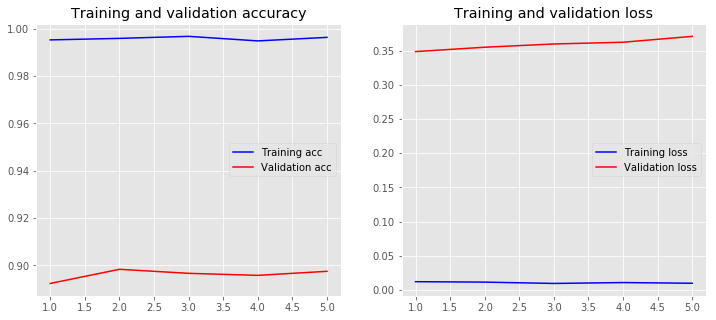

In [52]:
plot_history(history)

# Model Evaluation: Test Data

In [53]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.902255654335022


Confusion matrix, without normalization


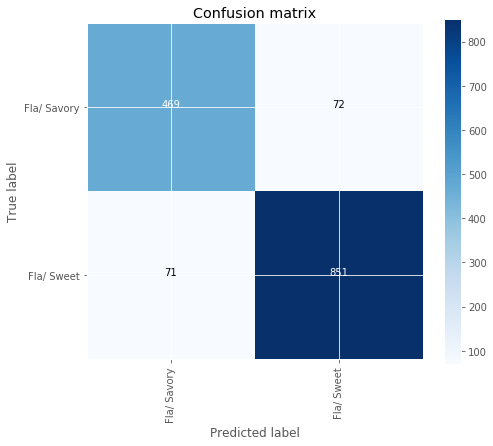

In [54]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [55]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.7902084087511018

In [56]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,Fla/ Savory,0.868519,0.866913,0.867715,541
1,Fla/ Sweet,0.921993,0.922993,0.922493,922


In [65]:
tmp = pd.DataFrame(data = cnf_matrix,index = text_labels, columns = text_labels)
tmp["total"] = tmp.sum(axis=1)
accuracy= {"Category":[],"Accuracy":[]}
for i in range(tmp.shape[0]):
    accuracy["Category"].append(tmp.index[i])
    accuracy["Accuracy"].append(tmp.iloc[i,i]/tmp.loc[tmp.index[i],"total"])

print("Accuracy:")
print(pd.DataFrame(accuracy))

Accuracy:
      Category  Accuracy
0  Fla/ Savory  0.866913
1   Fla/ Sweet  0.922993


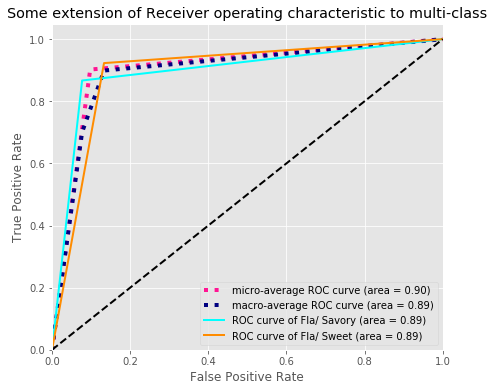

In [66]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.86


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.86')

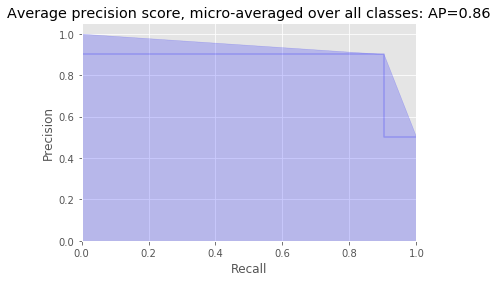

In [68]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

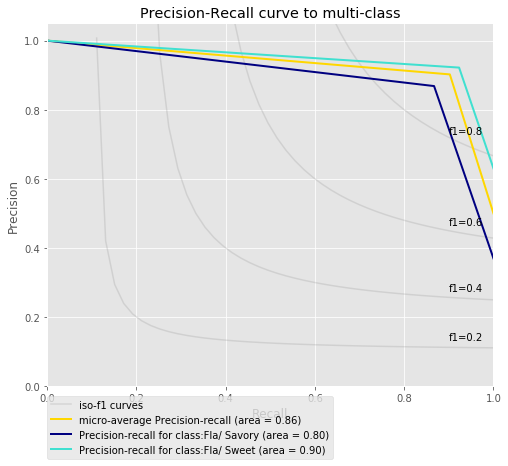

In [69]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()

# Trying globalmaxpool1D layer after enbedding

In [71]:
from keras.models import Sequential
from keras import layers

embedding_dim = 20

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
# model.add(layers.Flatten())
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_127 (Embedding)    (None, 26, 20)            137600    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 20)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_254 (Dense)            (None, 2)                 22        
Total params: 137,832
Trainable params: 137,832
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [73]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9972
Valid Accuracy:  0.9044
Testing Accuracy:  0.9064


In [74]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

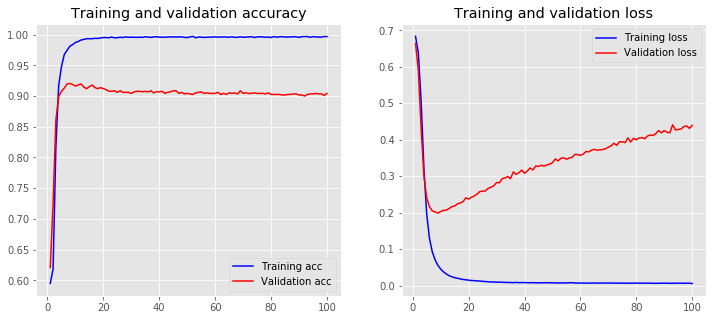

In [75]:
plot_history(history)

# Hyperparameter Tuning

In [76]:
# from keras.models import Sequential
# from keras import layers

# embedding_dim = 20

# model = Sequential()
# model.add(layers.Embedding(input_dim=vocab_size, 
#                            output_dim=embedding_dim, 
#                            input_length=maxlen))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(3, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [81]:
def create_model(learning_rate=0.01, activation='relu', embedding_dim=20, n_dense=10):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
#     model.add(layers.Flatten())
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(n_dense, activation=activation))
    model.add(layers.Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [82]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001],
          'embedding_dim' : [10,15,20,25,30],
          'n_dense' : [5,10,15,20]
         }

In [83]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [84]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [85]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
3120/3120 [==============================] - 1s 393us/step - loss: 0.6808 - accuracy: 0.5737
Epoch 2/10
3120/3120 [==============================] - 1s 168us/step - loss: 0.6358 - accuracy: 0.6109
Epoch 3/10
3120/3120 [==============================] - 1s 184us/step - loss: 0.4755 - accuracy: 0.8317
Epoch 4/10
3120/3120 [==============================] - 1s 181us/step - loss: 0.2918 - accuracy: 0.9093
Epoch 5/10
3120/3120 [==============================] - 1s 175us/step - loss: 0.1985 - accuracy: 0.9385
Epoch 6/10
3120/3120 [==============================] - 1s 190us/step - loss: 0.1470 - accuracy: 0.9548
Epoch 7/10
3120/3120 [==============================] - 1s 191us/step - loss: 0.1154 - accuracy: 0.9654
Epoch 8/10
3120/3120 [==============================] - 1s 187us/step - loss: 0.0934 - accuracy: 0.9712
Epoch 9/10
3120/3120 [==============================] - 1s 187us/step - loss: 0.0777 - accuracy: 0.9766
Epoch 10/10
3120/3120 [=====================

3121/3121 [==============================] - 1s 340us/step - loss: 0.0144 - accuracy: 0.9942
Epoch 15/30
3121/3121 [==============================] - 1s 339us/step - loss: 0.0141 - accuracy: 0.9939
Epoch 16/30
3121/3121 [==============================] - 1s 338us/step - loss: 0.0123 - accuracy: 0.9952
Epoch 17/30
3121/3121 [==============================] - 1s 338us/step - loss: 0.0122 - accuracy: 0.9952
Epoch 18/30
3121/3121 [==============================] - 1s 339us/step - loss: 0.0130 - accuracy: 0.9936
Epoch 19/30
3121/3121 [==============================] - 1s 340us/step - loss: 0.0114 - accuracy: 0.9955
Epoch 20/30
3121/3121 [==============================] - 1s 351us/step - loss: 0.0101 - accuracy: 0.9958
Epoch 21/30
3121/3121 [==============================] - 1s 338us/step - loss: 0.0115 - accuracy: 0.9949
Epoch 22/30
3121/3121 [==============================] - 1s 337us/step - loss: 0.0114 - accuracy: 0.9942
Epoch 23/30
3121/3121 [==============================] - 1s 349us/s

Epoch 8/10
3121/3121 [==============================] - 1s 352us/step - loss: 0.0136 - accuracy: 0.9981
Epoch 9/10
3121/3121 [==============================] - 1s 399us/step - loss: 0.0106 - accuracy: 0.9981
Epoch 10/10
3121/3121 [==============================] - 0s 107us/step
Epoch 1/30
3120/3120 [==============================] - 1s 368us/step - loss: 0.6897 - accuracy: 0.5314
Epoch 2/30
3120/3120 [==============================] - 0s 105us/step - loss: 0.6610 - accuracy: 0.5946
Epoch 3/30
3120/3120 [==============================] - 0s 104us/step - loss: 0.5877 - accuracy: 0.7099
Epoch 4/30
3120/3120 [==============================] - 0s 102us/step - loss: 0.4141 - accuracy: 0.8808
Epoch 5/30
3120/3120 [==============================] - 0s 101us/step - loss: 0.2413 - accuracy: 0.9285
Epoch 6/30
3120/3120 [==============================] - 0s 102us/step - loss: 0.1538 - accuracy: 0.9577
Epoch 7/30
3120/3120 [==============================] - 0s 100us/step - loss: 0.1100 - accuracy: 

3121/3121 [==============================] - 0s 98us/step - loss: 0.0138 - accuracy: 0.9984
Epoch 14/30
3121/3121 [==============================] - 0s 101us/step - loss: 0.0116 - accuracy: 0.9984
Epoch 15/30
3121/3121 [==============================] - 0s 101us/step - loss: 0.0099 - accuracy: 0.9984
Epoch 16/30
3121/3121 [==============================] - 0s 103us/step - loss: 0.0084 - accuracy: 0.9984
Epoch 17/30
3121/3121 [==============================] - 0s 103us/step - loss: 0.0070 - accuracy: 0.9994
Epoch 18/30
3121/3121 [==============================] - 0s 108us/step - loss: 0.0061 - accuracy: 0.9994
Epoch 19/30
3121/3121 [==============================] - 0s 105us/step - loss: 0.0050 - accuracy: 0.9994
Epoch 20/30
3121/3121 [==============================] - 0s 107us/step - loss: 0.0044 - accuracy: 0.9994
Epoch 21/30
3121/3121 [==============================] - 0s 102us/step - loss: 0.0039 - accuracy: 0.9994
Epoch 22/30
3121/3121 [==============================] - 0s 116us/st

3121/3121 [==============================] - 0s 97us/step - loss: 0.0122 - accuracy: 0.9984
Epoch 19/20
3121/3121 [==============================] - 0s 99us/step - loss: 0.0107 - accuracy: 0.9984
Epoch 20/20
3121/3121 [==============================] - 0s 32us/step
Epoch 1/20
3120/3120 [==============================] - 2s 605us/step - loss: 0.6686 - accuracy: 0.5923
Epoch 2/20
3120/3120 [==============================] - 1s 327us/step - loss: 0.5477 - accuracy: 0.7420
Epoch 3/20
3120/3120 [==============================] - 1s 321us/step - loss: 0.3352 - accuracy: 0.8901
Epoch 4/20
3120/3120 [==============================] - 1s 326us/step - loss: 0.2042 - accuracy: 0.9404
Epoch 5/20
3120/3120 [==============================] - 1s 330us/step - loss: 0.1347 - accuracy: 0.9612
Epoch 6/20
3120/3120 [==============================] - 1s 328us/step - loss: 0.0959 - accuracy: 0.9712
Epoch 7/20
3120/3120 [==============================] - 1s 321us/step - loss: 0.0711 - accuracy: 0.9798
Epoch 

3120/3120 [==============================] - 1s 190us/step
Epoch 1/10
3121/3121 [==============================] - 2s 521us/step - loss: 0.6745 - accuracy: 0.6011
Epoch 2/10
3121/3121 [==============================] - 1s 212us/step - loss: 0.5863 - accuracy: 0.6783
Epoch 3/10
3121/3121 [==============================] - 1s 227us/step - loss: 0.3668 - accuracy: 0.8629
Epoch 4/10
3121/3121 [==============================] - 1s 260us/step - loss: 0.2217 - accuracy: 0.9253
Epoch 5/10
3121/3121 [==============================] - 1s 237us/step - loss: 0.1491 - accuracy: 0.9478
Epoch 6/10
3121/3121 [==============================] - 1s 240us/step - loss: 0.1081 - accuracy: 0.9648
Epoch 7/10
3121/3121 [==============================] - 1s 251us/step - loss: 0.0829 - accuracy: 0.9728
Epoch 8/10
3121/3121 [==============================] - 1s 249us/step - loss: 0.0652 - accuracy: 0.9785
Epoch 9/10
3121/3121 [==============================] - 1s 243us/step - loss: 0.0532 - accuracy: 0.9840
Epoch

3120/3120 [==============================] - 1s 372us/step - loss: 0.0132 - accuracy: 0.9942
Epoch 24/30
3120/3120 [==============================] - 1s 360us/step - loss: 0.0143 - accuracy: 0.9936
Epoch 25/30
3120/3120 [==============================] - 1s 364us/step - loss: 0.0135 - accuracy: 0.9939
Epoch 26/30
3120/3120 [==============================] - 1s 378us/step - loss: 0.0133 - accuracy: 0.9933
Epoch 27/30
3120/3120 [==============================] - 1s 359us/step - loss: 0.0135 - accuracy: 0.9939
Epoch 28/30
3120/3120 [==============================] - 1s 371us/step - loss: 0.0137 - accuracy: 0.9936
Epoch 29/30
3120/3120 [==============================] - 1s 375us/step - loss: 0.0137 - accuracy: 0.9933
Epoch 30/30
3120/3120 [==============================] - 0s 128us/step
Epoch 1/30
3121/3121 [==============================] - 2s 682us/step - loss: 0.6621 - accuracy: 0.6021
Epoch 2/30
3121/3121 [==============================] - 1s 367us/step - loss: 0.4521 - accuracy: 0.813

3120/3120 [==============================] - 0s 95us/step - loss: 0.1239 - accuracy: 0.9699
Epoch 9/30
3120/3120 [==============================] - 0s 95us/step - loss: 0.0972 - accuracy: 0.9747
Epoch 10/30
3120/3120 [==============================] - 0s 95us/step - loss: 0.0793 - accuracy: 0.9788
Epoch 11/30
3120/3120 [==============================] - 0s 96us/step - loss: 0.0672 - accuracy: 0.9808
Epoch 12/30
3120/3120 [==============================] - 0s 91us/step - loss: 0.0581 - accuracy: 0.9833
Epoch 13/30
3120/3120 [==============================] - 0s 92us/step - loss: 0.0499 - accuracy: 0.9846
Epoch 14/30
3120/3120 [==============================] - 0s 93us/step - loss: 0.0439 - accuracy: 0.9875
Epoch 15/30
3120/3120 [==============================] - 0s 94us/step - loss: 0.0395 - accuracy: 0.9888
Epoch 16/30
3120/3120 [==============================] - 0s 97us/step - loss: 0.0355 - accuracy: 0.9885
Epoch 17/30
3120/3120 [==============================] - 0s 94us/step - loss:

3121/3121 [==============================] - 0s 107us/step - loss: 0.0063 - accuracy: 0.9990
Epoch 25/30
3121/3121 [==============================] - 0s 111us/step - loss: 0.0057 - accuracy: 0.9994
Epoch 26/30
3121/3121 [==============================] - 0s 95us/step - loss: 0.0051 - accuracy: 0.9994
Epoch 27/30
3121/3121 [==============================] - 0s 96us/step - loss: 0.0046 - accuracy: 0.9990
Epoch 28/30
3121/3121 [==============================] - 0s 94us/step - loss: 0.0042 - accuracy: 0.9994
Epoch 29/30
3121/3121 [==============================] - 0s 95us/step - loss: 0.0037 - accuracy: 0.9994
Epoch 30/30
3121/3121 [==============================] - 0s 33us/step
Epoch 1/30
3120/3120 [==============================] - 1s 435us/step - loss: 0.6726 - accuracy: 0.5929
Epoch 2/30
3120/3120 [==============================] - 0s 151us/step - loss: 0.6418 - accuracy: 0.5929
Epoch 3/30
3120/3120 [==============================] - 0s 153us/step - loss: 0.5608 - accuracy: 0.6567
Epoc

3121/3121 [==============================] - 0s 156us/step - loss: 0.1003 - accuracy: 0.9840
Epoch 10/30
3121/3121 [==============================] - 1s 169us/step - loss: 0.0760 - accuracy: 0.9872
Epoch 11/30
3121/3121 [==============================] - 1s 165us/step - loss: 0.0593 - accuracy: 0.9907
Epoch 12/30
3121/3121 [==============================] - 0s 149us/step - loss: 0.0477 - accuracy: 0.9930
Epoch 13/30
3121/3121 [==============================] - 0s 150us/step - loss: 0.0395 - accuracy: 0.9933
Epoch 14/30
3121/3121 [==============================] - 0s 150us/step - loss: 0.0332 - accuracy: 0.9949
Epoch 15/30
3121/3121 [==============================] - 0s 153us/step - loss: 0.0283 - accuracy: 0.9958
Epoch 16/30
3121/3121 [==============================] - 0s 152us/step - loss: 0.0243 - accuracy: 0.9965
Epoch 17/30
3121/3121 [==============================] - 0s 152us/step - loss: 0.0214 - accuracy: 0.9971
Epoch 18/30
3121/3121 [==============================] - 0s 155us/s

3121/3121 [==============================] - 0s 100us/step - loss: 0.0210 - accuracy: 0.9942
Epoch 26/30
3121/3121 [==============================] - 0s 97us/step - loss: 0.0194 - accuracy: 0.9955
Epoch 27/30
3121/3121 [==============================] - 0s 97us/step - loss: 0.0183 - accuracy: 0.9949
Epoch 28/30
3121/3121 [==============================] - 0s 112us/step - loss: 0.0174 - accuracy: 0.9942
Epoch 29/30
3121/3121 [==============================] - 0s 111us/step - loss: 0.0163 - accuracy: 0.9952
Epoch 30/30
3121/3121 [==============================] - 0s 32us/step
Epoch 1/30
3121/3121 [==============================] - 1s 401us/step - loss: 0.6801 - accuracy: 0.5960
Epoch 2/30
3121/3121 [==============================] - 0s 98us/step - loss: 0.6513 - accuracy: 0.6142
Epoch 3/30
3121/3121 [==============================] - 0s 97us/step - loss: 0.6113 - accuracy: 0.6155
Epoch 4/30
3121/3121 [==============================] - 0s 97us/step - loss: 0.5335 - accuracy: 0.7103
Epoch 

3120/3120 [==============================] - 1s 222us/step - loss: 0.0525 - accuracy: 0.9821
Epoch 9/10
3120/3120 [==============================] - 1s 228us/step - loss: 0.0430 - accuracy: 0.9840
Epoch 10/10
3120/3120 [==============================] - 0s 73us/step
Epoch 1/10
3121/3121 [==============================] - 2s 639us/step - loss: 0.6691 - accuracy: 0.6008
Epoch 2/10
3121/3121 [==============================] - 1s 227us/step - loss: 0.5837 - accuracy: 0.6764
Epoch 3/10
3121/3121 [==============================] - 1s 243us/step - loss: 0.3442 - accuracy: 0.8795
Epoch 4/10
3121/3121 [==============================] - 1s 280us/step - loss: 0.1848 - accuracy: 0.9414
Epoch 5/10
3121/3121 [==============================] - 1s 275us/step - loss: 0.1127 - accuracy: 0.9664
Epoch 6/10
3121/3121 [==============================] - 1s 195us/step - loss: 0.0747 - accuracy: 0.9782
Epoch 7/10
3121/3121 [==============================] - 1s 202us/step - loss: 0.0540 - accuracy: 0.9840
Epoch

3121/3121 [==============================] - 1s 450us/step - loss: 0.0079 - accuracy: 0.9990
Epoch 11/20
3121/3121 [==============================] - 1s 468us/step - loss: 0.0064 - accuracy: 0.9990
Epoch 12/20
3121/3121 [==============================] - 1s 453us/step - loss: 0.0048 - accuracy: 0.9990
Epoch 13/20
3121/3121 [==============================] - 1s 454us/step - loss: 0.0034 - accuracy: 0.9994
Epoch 14/20
3121/3121 [==============================] - 1s 451us/step - loss: 0.0028 - accuracy: 0.9997
Epoch 15/20
3121/3121 [==============================] - 1s 447us/step - loss: 0.0024 - accuracy: 0.9997
Epoch 16/20
3121/3121 [==============================] - 1s 453us/step - loss: 0.0025 - accuracy: 0.9994
Epoch 17/20
3121/3121 [==============================] - 1s 450us/step - loss: 0.0022 - accuracy: 0.9994
Epoch 18/20
3121/3121 [==============================] - 1s 453us/step - loss: 0.0020 - accuracy: 0.9994
Epoch 19/20
3121/3121 [==============================] - 1s 452us/s

Epoch 4/20
3120/3120 [==============================] - 1s 229us/step - loss: 0.1824 - accuracy: 0.9417
Epoch 5/20
3120/3120 [==============================] - 1s 225us/step - loss: 0.1174 - accuracy: 0.9663
Epoch 6/20
3120/3120 [==============================] - 1s 220us/step - loss: 0.0828 - accuracy: 0.9753
Epoch 7/20
3120/3120 [==============================] - 1s 224us/step - loss: 0.0632 - accuracy: 0.9801
Epoch 8/20
3120/3120 [==============================] - 1s 222us/step - loss: 0.0485 - accuracy: 0.9853
Epoch 9/20
3120/3120 [==============================] - 1s 223us/step - loss: 0.0396 - accuracy: 0.9878
Epoch 10/20
3120/3120 [==============================] - 1s 225us/step - loss: 0.0328 - accuracy: 0.9891
Epoch 11/20
3120/3120 [==============================] - 1s 224us/step - loss: 0.0286 - accuracy: 0.9901
Epoch 12/20
3120/3120 [==============================] - 1s 222us/step - loss: 0.0255 - accuracy: 0.9920
Epoch 13/20
3120/3120 [==============================] - 1s 2

Epoch 19/20
3120/3120 [==============================] - 1s 282us/step - loss: 0.0213 - accuracy: 0.9910
Epoch 20/20
3120/3120 [==============================] - 0s 155us/step
Epoch 1/20
3121/3121 [==============================] - 2s 683us/step - loss: 0.6754 - accuracy: 0.5969
Epoch 2/20
3121/3121 [==============================] - 1s 286us/step - loss: 0.5792 - accuracy: 0.7078
Epoch 3/20
3121/3121 [==============================] - 1s 286us/step - loss: 0.3490 - accuracy: 0.8831
Epoch 4/20
3121/3121 [==============================] - 1s 284us/step - loss: 0.2047 - accuracy: 0.9318
Epoch 5/20
3121/3121 [==============================] - 1s 286us/step - loss: 0.1339 - accuracy: 0.9561
Epoch 6/20
3121/3121 [==============================] - 1s 281us/step - loss: 0.0958 - accuracy: 0.9712
Epoch 7/20
3121/3121 [==============================] - 1s 283us/step - loss: 0.0732 - accuracy: 0.9763
Epoch 8/20
3121/3121 [==============================] - 1s 279us/step - loss: 0.0577 - accuracy:

3121/3121 [==============================] - 2s 484us/step - loss: 0.0266 - accuracy: 0.9913
Epoch 13/20
3121/3121 [==============================] - 2s 513us/step - loss: 0.0229 - accuracy: 0.9923
Epoch 14/20
3121/3121 [==============================] - 2s 503us/step - loss: 0.0205 - accuracy: 0.9939
Epoch 15/20
3121/3121 [==============================] - 2s 499us/step - loss: 0.0191 - accuracy: 0.9917
Epoch 16/20
3121/3121 [==============================] - 1s 480us/step - loss: 0.0174 - accuracy: 0.9936
Epoch 17/20
3121/3121 [==============================] - 2s 496us/step - loss: 0.0152 - accuracy: 0.9946
Epoch 18/20
3121/3121 [==============================] - 2s 501us/step - loss: 0.0143 - accuracy: 0.9949
Epoch 19/20
3121/3121 [==============================] - 2s 500us/step - loss: 0.0140 - accuracy: 0.9949
Epoch 20/20
3121/3121 [==============================] - 1s 249us/step
Epoch 1/20
3121/3121 [==============================] - 3s 998us/step - loss: 0.6849 - accuracy: 0.61

In [86]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.23477335992060114 and Best Params:  {'n_dense': 10, 'learning_rate': 0.0001, 'epochs': 10, 'embedding_dim': 15, 'batch_size': 32, 'activation': 'tanh'}


## Fit Best Model

In [87]:
model = create_model(learning_rate=0.0001, activation='tanh', embedding_dim=15, n_dense=10)

In [90]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=10,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=32)

In [91]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9972
Valid Accuracy:  0.9009
Testing Accuracy:  0.8982


In [92]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

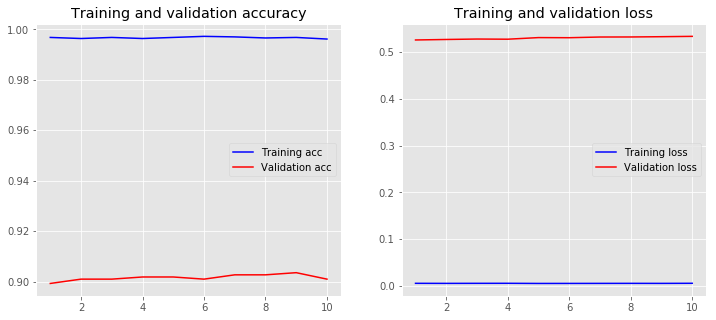

In [93]:
plot_history(history)

# Model Evaluation: Test Data

In [94]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.8981544971466064


Confusion matrix, without normalization


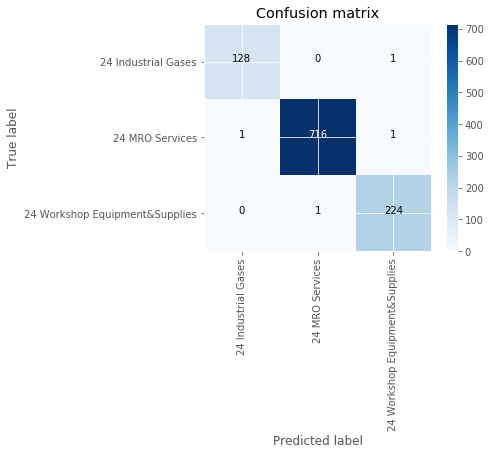

In [202]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [203]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9924358822834181

In [204]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


,Labels,precision,recall,fscore,support
0,24 Industrial Gases,0.992248,0.992248,0.992248,129
1,24 MRO Services,0.998605,0.997214,0.997909,718
2,24 Workshop Equipment&Supplies,0.991150,0.995556,0.993348,225


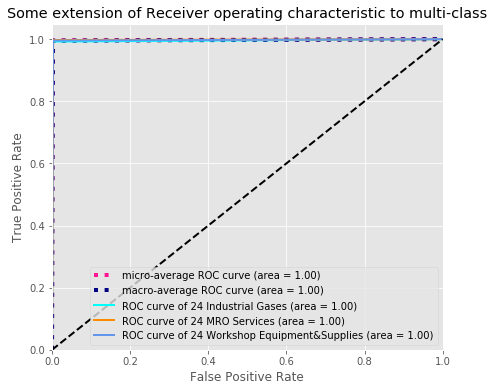

In [205]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [206]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

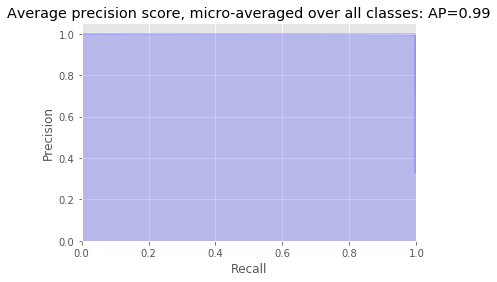

In [207]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

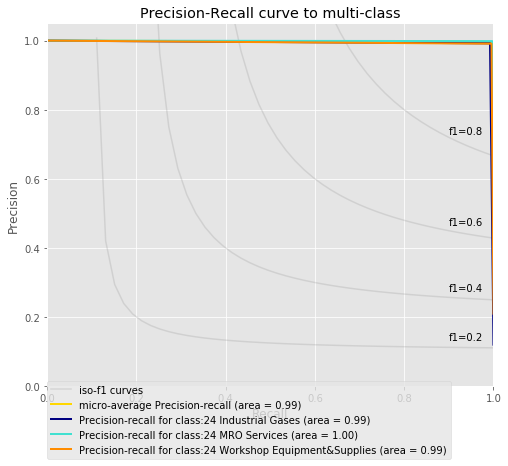

In [208]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()